In [ ]:
import numpy as np
import cv2 as cv
from scipy.signal import butter, filtfilt

from PIL import Image
import matplotlib.pyplot as plt

import imageio


# 1.0 Optical Flow

In [ ]:
def read_video_into_numpy(filename):
  cap = cv.VideoCapture(filename)
  frames = []
  while cap.isOpened():
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
      print("Can't receive frame (stream end?). Exiting ...")
      break

    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    frames.append(frame)

  cap.release()
  video = np.stack(frames, axis=0)#converts to numpy array(T,H,W,C)
  video = np.transpose(video, (1,2,3,0))#(T,H,W,C)->(H,W,C,T)
  return frames

Cars = read_video_into_numpy('cars.mp4')

Can't receive frame (stream end?). Exiting ...


### 1.1 Lucas_Kanade

#### 1. Select corners

[  5  10  17  18  18  46  47  50  51  51  52  52  56  61  62  72  72  73
  73  73  78  82  82  83  83  86  89  89  89  90  90  91  91  94  94  94
  95 128 129 138 153 153 153 153 154 154 154 154 155 163 164 164 165 174
 176 177 177 177 178 185 186 213 294 338]
[203 432 212 204 212 488 488 262 260 262 252 260 146 148 148 186 187 172
 186 187 467 436 437 436 437 439 170 171 172 170 171 436 437 182 187 188
 182 196 126 194 106 201 208 209 106 201 208 209 115  97  97  98  98  88
 324 307 308 324 308  78  78  69 393 352]


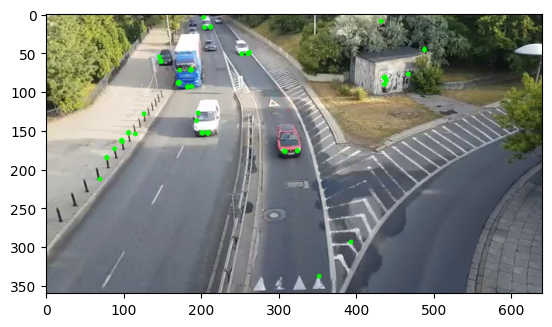

In [ ]:
# Read the first frame of the video
first_frame = Cars[0]
first_gray = cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)

# Detect corners in the first frame using the Harris corner detector
first_dst = cv.cornerHarris(first_gray, 2, 3, 0.04)
first_y, first_x = np.where(first_dst > 0.35 * first_dst.max())

print(first_y)
print(first_x)

for x, y in zip(first_x, first_y):
    #x, y = point[0].astype(np.int32)
    cv.circle(first_frame, (x, y), 3, (0, 255, 0), -1)

plt.imshow(first_frame)
#plt.imshow(first_gray)

#### 2. Track the points

In [ ]:
import math

def gaussian2D(sigma, kernel_size):
  kernel = np.zeros((kernel_size, kernel_size))
  for i in range(kernel_size):
    for j in range(kernel_size):
        x = i - kernel_size // 2
        y = j - kernel_size // 2
        kernel[i, j] = np.exp(-(x**2 + y**2) / (2 * sigma**2))
  kernel /= (2*math.pi*sigma**2)
  return kernel 

def gausspyr(I, n_levels):
    pyramid = [I]
    #kernel_size = 2 * math.ceil(3*sigma) + 1
    #kernel = gaussian2D(sigma, kernel_size)

    for i in range(1, n_levels):
      I = cv.pyrDown(I)
      pyramid.append(I)
    return pyramid


In [ ]:
def get_derivatives(A):
  dx = np.array([[0, 0, 0],
                 [0, -1, 1],
                 [0, 0, 0]])
  dy = np.array([[0, 0, 0],
                 [0, -1, 0],
                 [0, 1, 0]])
  Ax = cv.filter2D(A, ddepth=-1, kernel=dx)
  Ay = cv.filter2D(A, ddepth=-1, kernel=dy)
  return Ax, Ay

In [ ]:
# sec_frame = Cars[1]
# sec_gray = cv.cvtColor(sec_frame, cv.COLOR_BGR2GRAY)

In [ ]:
# im_list = []
im_list = [first_frame]
j = 0

while j < len(Cars)-1:
  first_frame = Cars[j]
  first_gray = cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)

  sec_frame = Cars[j+1]
  sec_gray = cv.cvtColor(sec_frame, cv.COLOR_BGR2GRAY) 

  next_pts = np.zeros((len(first_y), 1, 2))

  for i in range(len(first_y)):
    temp = np.zeros((1,2))
    temp[0,0], temp[0,1] = [first_x[i], first_y[i]]

    #print(temp)

    gpyrA, gpyrB = gausspyr(first_gray, 3), gausspyr(sec_gray, 3)

    #print(gpyrA[5].shape)

    F = np.zeros((len(gpyrA), 1, 2))
    F[len(gpyrA)-1, :] = [0, 0]
    
    for l in reversed(range(len(gpyrA))):
      pointA_l = temp / 2**l #scale point coordinates to match resolution level

      window_size = 5

      n_iters = 5

      Ix, Iy = get_derivatives(gpyrA[l])
      
      #G <- spatial gradient matrix centered around pointA using window_size
      y0, x0 = int(pointA_l[0,0]), int(pointA_l[0,1])
      h, w = Ix.shape[0], Ix.shape[1]
      x1, y1 = max(0, x0 - window_size), max(0, y0 - window_size)
      x2, y2 = min(w - 1, x0 + window_size), min(h - 1, y0 + window_size)   
      G = np.zeros((2, 2))

      G[0, 0] = np.sum((Ix[y1:y2+1, x1:x2+1] * Ix[y1:y2+1, x1:x2+1]))  # Ixx
      G[0, 1] = np.sum((Ix[y1:y2+1, x1:x2+1] * Iy[y1:y2+1, x1:x2+1]))  # Ixy
      G[1, 0] = np.sum((Ix[y1:y2+1, x1:x2+1] * Iy[y1:y2+1, x1:x2+1]))  # Iyx
      G[1, 1] = np.sum((Iy[y1:y2+1, x1:x2+1] * Iy[y1:y2+1, x1:x2+1]))  # Iyy

      f = np.zeros((n_iters+1, 1, 2 ))
      f[0, :] = [[0, 0]] #initialize flow as zeros 

      for k in range(1, n_iters + 1):
        b = np.zeros((2, 1))
        for v in range(y1,y2+1):
          for u in range(x1,x2+1):
            if int(v + f[k-1,0,1]) > (h - 1) or int(u + f[k-1,0,0]) > (w - 1) or int(v + f[k-1,0,1]) < 0 or int(u + f[k-1,0,0]) < 0:
              continue
            b[0, 0] += Ix[v,u] * (gpyrA[l][v, u] - gpyrB[l][int(v + f[k-1,0,1]), int(u + f[k-1,0,0])])
            b[1, 0] += Iy[v,u] * (gpyrA[l][v, u] - gpyrB[l][int(v + f[k-1,0,1]), int(u + f[k-1,0,0])])
        f[k, :] = f[k-1, :] + np.transpose(np.linalg.pinv(G) @ b)

      if l > 0:
        F[l-1, :] = 2 * (F[l,:] + f[n_iters, :]) #flow initialization for next level
      else:
        F_final = np.array((1,2))
        F_final = F[l,:] + f[n_iters, :]

    next_pts[i,0,:] = temp + F_final

  for point in next_pts:
    x, y = point[0].astype(np.int32)
    cv.circle(sec_frame, (x, y), 3, (0, 255, 0), -1)

  im_list.append(sec_frame)

  first_x , first_y = next_pts[:,:,0].ravel(), next_pts[:,:,1].ravel()

  j = j + 1

imageio.mimsave('tracking.gif', im_list, fps=10)
#print(next_pts)

<ipython-input-270-4259e9d877b7>:20: RuntimeWarning: overflow encountered in ubyte_scalars
  gpyrA, gpyrB = gausspyr(first_gray, 3), gausspyr(sec_gray, 3)


In [ ]:
print(F[:,:,0].ravel().shape)
print(first_x.shape)

(3,)
(64,)


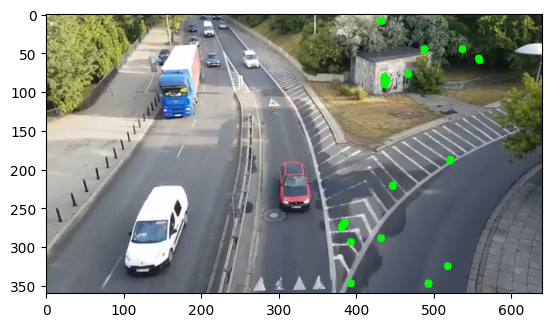

In [ ]:
for point in next_pts:
    x, y = point[0].astype(np.int32)
    cv.circle(sec_frame, (x, y), 5, (0, 255, 0), -1)

plt.imshow(sec_frame)

In [ ]:
im_list = [first_frame]

im_list.append(sec_frame)

imageio.mimsave('tracking.gif', im_list, fps=10)

In [ ]:
def iterative_lucas_kanade(imgA, imgB, pointA, window_size, n_iters):
    #Ix <- Derivative of imgA with respect to x 
    #Iy <- Derivative of imgA with respect to y 
    Ix, Iy = get_derivatives(imgA)
    
    #G <- spatial gradient matrix centered around pointA using window_size
    y0, x0 = int(pointA[0,0]), int(pointA[0,1])
    h, w = Ix.shape[0], Ix.shape[1]
    x1, y1 = max(0, x0 - window_size), max(0, y0 - window_size)
    x2, y2 = min(w - 1, x0 + window_size), min(h - 1, y0 + window_size)   
    G = np.zeros((2, 2))

    G[0, 0] = np.sum((Ix[y1:y2+1, x1:x2+1] * Ix[y1:y2+1, x1:x2+1]))  # Ixx
    G[0, 1] = np.sum((Ix[y1:y2+1, x1:x2+1] * Iy[y1:y2+1, x1:x2+1]))  # Ixy
    G[1, 0] = np.sum((Ix[y1:y2+1, x1:x2+1] * Iy[y1:y2+1, x1:x2+1]))  # Iyx
    G[1, 1] = np.sum((Iy[y1:y2+1, x1:x2+1] * Iy[y1:y2+1, x1:x2+1]))  # Iyy

    F = np.zeros((n_iters+1, 1, 2 ))
    F[0, :] = [0, 0] #initialize flow as zeros 

    for k in range(1, n_iters + 1):
      b = np.zeros((2, 1))
      # map_imgB = np.zeros_like(imgB)
      for i in range(y1,y2+1):
        for j in range(x1,x2+1):
          if -1 < (i + F[k-1,0,0]) < (h + 1) and -1 < (j + F[k-1,0,1]) < (w + 1):
          # v, u = int(i + F[k-1,0,0]), int(j + F[k-1,0,1])
            b[0, 0] += Ix[i,j] * (imgA[i, j] - imgB[int(i + F[k-1,0,0]), int(j + F[k-1,0,1])])
            b[1, 0] += Iy[i,j] * (imgA[i, j] - imgB[int(i + F[k-1,0,0]), int(j + F[k-1,0,1])])

          # map_imgB[y, x] = imgB[map_y, map_x]

      # At = map_imgB - imgA

      
      # b[0, 0] = -np.sum(np.multiply(At[y1:y2+1, x1:x2+1], Ix[y1:y2+1, x1:x2+1]))
      # b[1, 0] = -np.sum(np.multiply(At[y1:y2+1, x1:x2+1], Iy[y1:y2+1, x1:x2+1])) 
      # b <- image patch mismatch subtracting imgA patch centered around pointA and imgB patch centered around pointA that has been estimated by flowing backwards using F[k-1, :]. (see lecture 10 slide 45 and CS233 Notes Pg6) 
      
      F[k, :] = F[k-1, :] + np.transpose(np.linalg.inv(G) @ b)
      
    return F[n_iters, :]

In [ ]:
def pyramidal_lucas_kanade(imgA, imgB, pointA):
  # gpyrA, gpryB <- Gaussian pyramids for image A and B 
  gpyrA, gpyrB = gausspyr(imgA, 6), gausspyr(imgB, 6)
  
  #F[l, :] <- [0, 0] initialize top of pyramid flow as zeros
  F = np.zeros((len(gpyrA), 1, 2))
  F[len(gpyrA)-1, :] = [0, 0]
  
  for l in reversed(range(len(gpyrA))):
    pointA_l = pointA / 2**l #scale point coordinates to match resolution level
    
    flow_guess = iterative_lucas_kanade(gpyrA[l], gpyrB[l], pointA_l, 10, 20) #flow guess for this resolution level using iterative LK

    if l > 0:
      F[l-1, :] = 2 * (F[l,:] + flow_guess) #flow initialization for next level
    else:
      F = np.array((1,2))
      F = (F[l,:] + flow_guess)

  return F
    
  #flow = pyramidal_lucas_kanade(imgA, imgB, pointA)

  # pointB = pointA + F
  # return pointB

In [ ]:
def iterative_points(prev_img, next_img, y_pts, x_pts):
  next_pts = np.zeros((len(y_pts), 1, 2))
  temp = np.zeros((1,2))

  for i in range(len(y_pts)):
    temp[0,0], temp[0,1] = [y_pts[i], x_pts[i]]
    next_pts[i,0,:] = temp + pyramidal_lucas_kanade(prev_img, next_img, temp)

  return next_pts



In [ ]:
NP = iterative_points(first_gray, sec_gray, first_y,first_x)

print(NP)

In [ ]:
j = 0

a = np.array([194, 138])

prev_frame = Cars[j]
prev_gray = cv.cvtColor(prev_frame, cv.COLOR_BGR2GRAY)

next_frame = Cars[j+1]
next_gray = cv.cvtColor(next_frame, cv.COLOR_BGR2GRAY) 

test = iterative_lucas_kanade(prev_gray, next_gray, a, 3, 20)

print(test)

test1 = pyramidal_lucas_kanade(prev_gray, next_gray, a)

print(test1)

cv.circle(prev_frame, (194, 138), 3, (0, 255, 0), -1)

plt.imshow(prev_frame)

# next_points = iterative_points(prev_gray, next_gray, first_y, first_x)

for n in range(next_points.shape[0]):
  x,y = next_points[n,0,:].astype(np.int32)
  cv.circle(next_frame, (x, y), 3, (0, 255, 0), -1)

#plt.imshow(prev_frame)
print(next_points[1,0,:].astype(np.int32))
x,y = next_points[n,0,:].astype(np.int32)
print(x)

In [ ]:
# Create a list to store the trajectories of each corner
trajectories = [[] for _ in range(len(first_x))]

im_list = []

j = 0

while j < len(Cars)-1:
    prev_frame = Cars[j]
    prev_gray = cv.cvtColor(prev_frame, cv.COLOR_BGR2GRAY)

    next_frame = Cars[j+1]
    next_gray = cv.cvtColor(next_frame, cv.COLOR_BGR2GRAY) 

    next_point = pyramidal_lucas_kanade(prev_gray, next_gray, a)

    # next_points = iterative_points(prev_gray, next_gray, first_y, first_x)

    #for i, (new) in enumerate(next_points):
    #    trajectories[i].append(new)
    cv.circle(next_frame, (x, y), 5, (0, 255, 0), -1)

    for n in range(next_points.shape[0]):
      x,y = next_points[n,0,:].astype(np.int32)
      cv.circle(next_frame, (x, y), 5, (0, 255, 0), -1)

    im_list.append(next_frame)

    j = j + 1

imageio.mimsave('tracking.gif', im_list, fps=10)

In [ ]:
plt.imshow(im_list[1])

In [ ]:
# Create a list to store the trajectories of each corner
trajectories = [[] for _ in range(len(first_x))]

im_list = []

# Loop through the remaining frames of the video
while True:
    # Read the next frame of the video
    ret, next_frame = cap.read()
    if not ret:
        break
    next_gray = cv.cvtColor(next_frame, cv.COLOR_BGR2GRAY)

    # Calculate the optical flow using Lucas-Kanade
    next_pts, status, err = cv.calcOpticalFlowPyrLK(prev_gray, next_gray, np.float32([(x, y) for x, y in zip(prev_x, prev_y)]), None)

    # Select the good points
    status = status.ravel() 
    good_new = next_pts[status == 1]
    good_old = np.float32([(x, y) for x, y in zip(prev_x, prev_y)])[status == 1]

    # Update the trajectories of the good points
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        trajectories[i].append(new)

    # Draw circles around the tracked points
    for point in good_new:
        x, y = point.ravel().astype(np.int32)
        cv.circle(next_frame, (x, y), 3, (0, 255, 0), -1)

    # Add the image to the list of output images
    im_list.append(next_frame)

    # Update the previous frame and points
    prev_gray = next_gray.copy()
    prev_x, prev_y = good_new[:, 0], good_new[:, 1]

# Release the video capture
cap.release()




In [ ]:
print(len(im_list))

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

plt.imshow(im_list[0])
plt.axis(False);

im = Image.fromarray(im_list[0])
im.save('tracking_frame0.jpg')

In [ ]:
plt.imshow(im_list[9])
plt.axis(False);

im = Image.fromarray(im_list[9])
im.save('tracking_frame9.jpg')

In [ ]:
plt.imshow(im_list[19])
plt.axis(False);

im = Image.fromarray(im_list[19])
im.save('tracking_frame19.jpg')

In [ ]:
plt.imshow(im_list[23])
plt.axis(False);

im = Image.fromarray(im_list[23])
im.save('tracking_frame23.jpg')

#### 3. Create a  gif

In [ ]:
# Save the output as a gif
imageio.mimsave('tracking.gif1', im_list, fps=10)

#### change window_size

In [ ]:
# Load the video file
cap = cv.VideoCapture('cars.mp4')

# Read the first frame of the video
ret, prev_frame = cap.read()
prev_gray = cv.cvtColor(prev_frame, cv.COLOR_BGR2GRAY)

# Detect corners in the first frame using the Harris corner detector
prev_dst = cv.cornerHarris(prev_gray, 2, 3, 0.04)
prev_y, prev_x = np.where(prev_dst > 0.1 * prev_dst.max())

# Create a list to store the trajectories of each corner
trajectories = [[] for _ in range(len(prev_x))]

im_list = []

# Loop through the remaining frames of the video
while True:
    # Read the next frame of the video
    ret, next_frame = cap.read()
    if not ret:
        break
    next_gray = cv.cvtColor(next_frame, cv.COLOR_BGR2GRAY)

    # Calculate the optical flow using Lucas-Kanade
    win_size = (15, 15)  # specify the window size
    lk_params = dict(winSize=win_size, maxLevel=2, criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))
    next_pts, status, err = cv.calcOpticalFlowPyrLK(prev_gray, next_gray, np.float32([(x, y) for x, y in zip(prev_x, prev_y)]), None, **lk_params)

    # Select the good points
    status = status.ravel() 
    good_new = next_pts[status == 1]
    good_old = np.float32([(x, y) for x, y in zip(prev_x, prev_y)])[status == 1]

    # Update the trajectories of the good points
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        trajectories[i].append(new)

    # Draw circles around the tracked points
    for point in good_new:
        x, y = point.ravel().astype(np.int32)
        cv.circle(next_frame, (x, y), 2, (0, 255, 0), -1)

    # Add the image to the list of output images
    im_list.append(next_frame)

    # Update the previous frame and points
    prev_gray = next_gray.copy()
    prev_x, prev_y = good_new[:, 0], good_new[:, 1]

# Release the video capture
cap.release()

# Save the output as a gif
imageio.mimsave('tracking_15*15.gif', im_list, fps=10)

In [ ]:
# Load the video file
cap = cv.VideoCapture('cars.mp4')

# Read the first frame of the video
ret, prev_frame = cap.read()
prev_gray = cv.cvtColor(prev_frame, cv.COLOR_BGR2GRAY)

# Detect corners in the first frame using the Harris corner detector
prev_dst = cv.cornerHarris(prev_gray, 2, 3, 0.04)
prev_y, prev_x = np.where(prev_dst > 0.1 * prev_dst.max())

# Create a list to store the trajectories of each corner
trajectories = [[] for _ in range(len(prev_x))]

im_list = []

# Loop through the remaining frames of the video
while True:
    # Read the next frame of the video
    ret, next_frame = cap.read()
    if not ret:
        break
    next_gray = cv.cvtColor(next_frame, cv.COLOR_BGR2GRAY)

    # Calculate the optical flow using Lucas-Kanade
    win_size = (50, 50)  # specify the window size
    lk_params = dict(winSize=win_size, maxLevel=2, criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))
    next_pts, status, err = cv.calcOpticalFlowPyrLK(prev_gray, next_gray, np.float32([(x, y) for x, y in zip(prev_x, prev_y)]), None, **lk_params)

    # Select the good points
    status = status.ravel() 
    good_new = next_pts[status == 1]
    good_old = np.float32([(x, y) for x, y in zip(prev_x, prev_y)])[status == 1]

    # Update the trajectories of the good points
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        trajectories[i].append(new)

    # Draw circles around the tracked points
    for point in good_new:
        x, y = point.ravel().astype(np.int32)
        cv.circle(next_frame, (x, y), 5, (0, 255, 0), -1)

    # Add the image to the list of output images
    im_list.append(next_frame)

    # Update the previous frame and points
    prev_gray = next_gray.copy()
    prev_x, prev_y = good_new[:, 0], good_new[:, 1]

# Release the video capture
cap.release()

# Save the output as a gif
imageio.mimsave('tracking_50*50.gif', im_list, fps=10)

### 1.2 Horn-Schunck

In [ ]:
def get_derivatives(A):
  dx = np.array([[0, 0, 0],
                 [0, -1, 1],
                 [0, 0, 0]])
  dy = np.array([[0, 0, 0],
                 [0, -1, 0],
                 [0, 1, 0]])
  Ax = cv.filter2D(A, ddepth=-1, kernel=dx)
  Ay = cv.filter2D(A, ddepth=-1, kernel=dy)
  return Ax, Ay

def gausspyr(I, n_levels):
    pyramid = [I]
    #kernel_size = 2 * math.ceil(3*sigma) + 1
    #kernel = gaussian2D(sigma, kernel_size)

    for i in range(1, n_levels):
      I = cv.pyrDown(I)
      pyramid.append(I)
    return pyramid

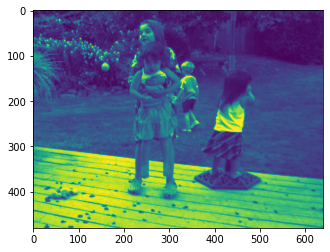

In [ ]:
frame1 = Image.open("frame10.png")
frame1 = np.array(frame1)

frame2 = Image.open("frame11.png")
frame2 = np.array(frame2)

prev_gray = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
next_gray = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)

# Set the parameters for Horn-Schunck algorithm
lamda = 0.05  # regularization parameter
num_iterations = 100  # number of iterations
epsilon = 0.001  # convergence threshold

plt.imshow(prev_gray)

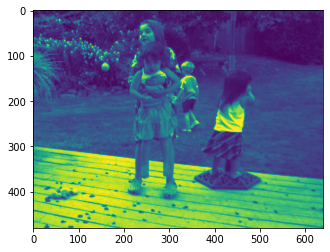

In [ ]:
plt.imshow(next_gray)

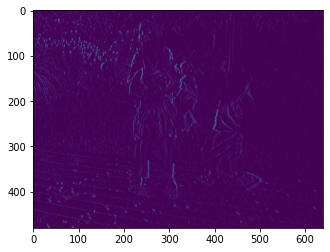

In [ ]:
Ax, Ay = get_derivatives(next_gray)

plt.imshow(Ax)

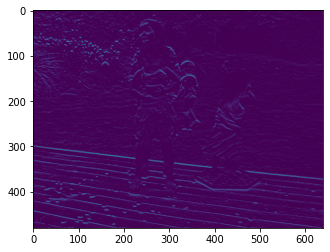

In [ ]:
plt.imshow(Ay)

In [ ]:
gpyrA, gpyrB = gausspyr(prev_gray, 5), gausspyr(next_gray, 5)
F = np.zeros((gpyrA[len(gpyrA)-1].shape[0],gpyrA[len(gpyrA)-1].shape[1], 2))


In [ ]:
for l in reversed(range(len(gpyrA))):
  Ax, Ay = get_derivatives(gpyrA[l])

  if F.shape[0] > Ax.shape[0]:
    F = np.delete(F, -1, axis = 0)

  At = np.zeros_like(gpyrB[l])
  for i in range(gpyrB[l].shape[0]): 
    for j in range(gpyrB[l].shape[1]):
      if -1 < (i + F[i,j,0]) < (gpyrB[l].shape[0] + 1) and -1 < (j + F[i,j,1]) < (gpyrB[l].shape[1] + 1):
        At[i, j] = gpyrB[l][int(i + F[i,j,0]), int(j + F[i,j,1])] - gpyrA[l][i, j]

  F_avg = np.zeros_like(F)
  F_avg[:,:,0] = cv.GaussianBlur(F[:,:,0], (5, 5), 0)
  F_avg[:,:,1] = cv.GaussianBlur(F[:,:,1], (5, 5), 0)


  B = Ax * F[:,:,0] + Ay * F[:,:,1] + At

  G = 1/lamda + Ax**2 + Ay**2

  F[:,:,0] = F_avg[:,:,0] + (B * Ax)/G
  F[:,:,1] = F_avg[:,:,1] + (B * Ay)/G

  if l > 0:
    temp_F = np.zeros((gpyrB[l].shape[0]*2, gpyrB[l].shape[1]*2, 2))
    temp_F[:,:,0] = 2 * (cv.pyrUp(F[:,:,0]))
    temp_F[:,:,1] = 2 * (cv.pyrUp(F[:,:,1]))
    if gpyrB[l-1].shape[0] % 2 == 1 and gpyrB[l-1].shape[1] % 2 == 0:
      # F = temp_F[0:gpyrB[l].shape[0]*2-1, : ,:]
      F = np.delete(temp_F, -1, axis = 0)
    if gpyrB[l-1].shape[0] % 2 == 0 and gpyrB[l-1].shape[1] % 2 == 1:
      # F = temp_F[:,0:gpyrB[l].shape[1]*2-1,:]
      F = np.delete(F, -1, axis = 1)
    if gpyrB[l-1].shape[0] % 2 == 1 and gpyrB[l-1].shape[1] % 2 == 1:
      F = temp_F[0:gpyrB[l].shape[0]*2-1,0:gpyrB[l].shape[1]*2-1,:]
    else:
      F = temp_F

flow_x = F[:,:,0]
flow_y = F[:,:,1]

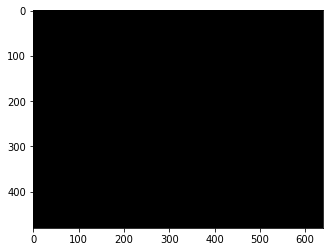

In [ ]:
hsv = np.zeros(frame1.shape, dtype=np.uint8)
hsv[..., 1] = 255
mag, ang = cv.cartToPolar(flow_x, flow_y)
hsv[..., 0] = ang * 180 / np.pi / 2
hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)
out = cv.cvtColor(hsv, cv.COLOR_HSV2RGB)

plt.imshow(out)

im = Image.fromarray(out)
im.save('Backyard_HS.jpg')

### 1.3 Improving Horn-Schunck with superpixels

# 2.0 Image Compression with PCA

### 2.1 Use PCA to model patches

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

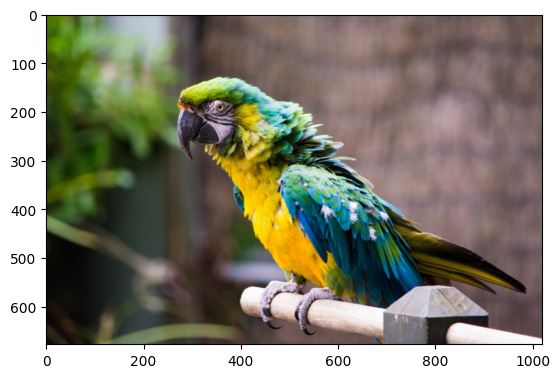

In [ ]:
img = Image.open('parrot.png')
img = np.array(img)

plt.imshow(img)

In [ ]:
height, width, _ = img.shape

# Set the patch size
patch_size = 16

max_row = height // patch_size
max_col = width // patch_size
max_patches = max_row * max_col

patch_nums = np.random.randint(0, max_patches, 1200)

print(max_patches)

2646


In [ ]:
patches = []

for patch_num in patch_nums:
    # Calculate the starting row and column of the patch
    row = patch_num // max_col
    col = patch_num % max_col
    start_row = row * patch_size
    start_col = col * patch_size

    # Extract the patch
    patch = img[start_row:start_row+patch_size, start_col:start_col+patch_size]

    # Add the patch to the list
    patches.append(patch)

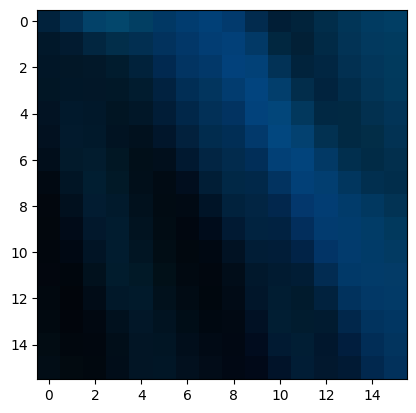

In [ ]:
plt.imshow(patches[100])

In [ ]:
patch_array = np.asarray(patches)

print(patch_array.shape)

m, n, l = patch_array.shape[1:]

patch_array = patch_array.reshape(patch_array.shape[0], m*n*l)
print(patch_array.shape)

(1200, 16, 16, 3)
(1200, 768)


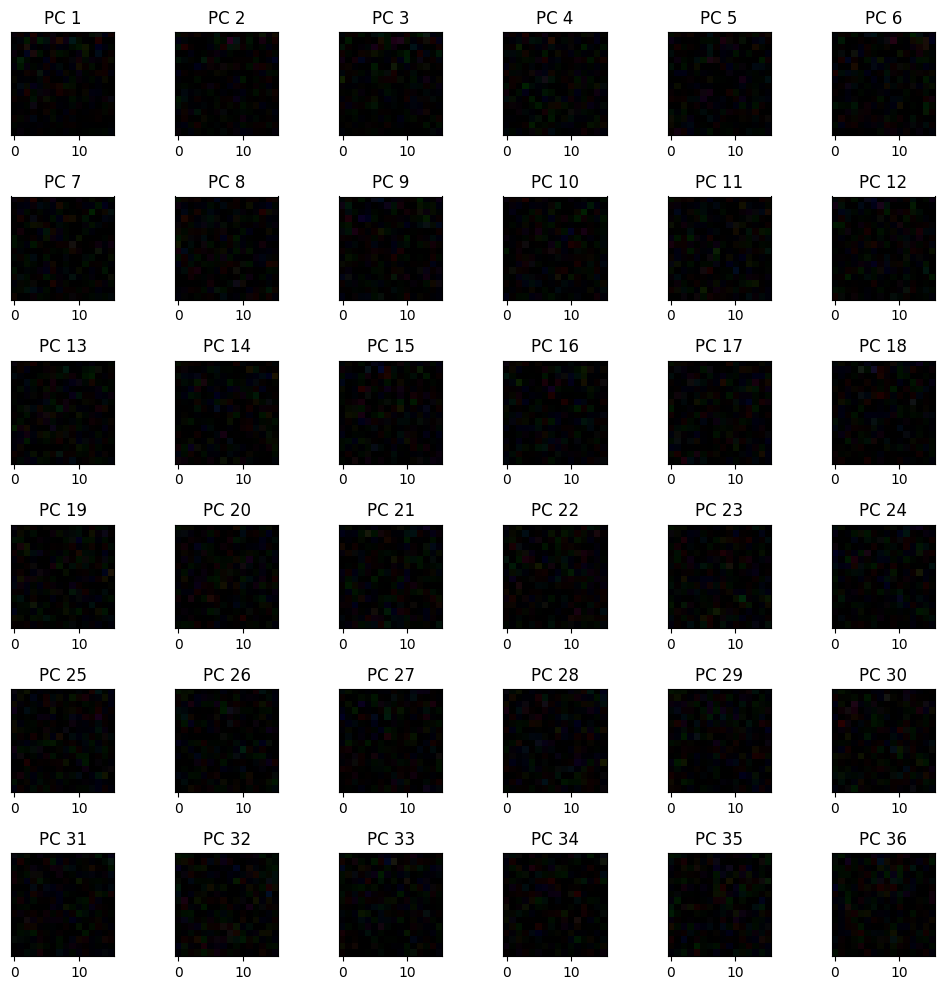

In [ ]:
mean_patch = np.mean(patch_array, axis=1)
centered_patches = patch_array - mean_patch[:, np.newaxis]

covariance_matrix = np.cov(centered_patches.T)
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(sorted_eigenvectors[i, :].reshape((16, 16, 3)))
    ax.set_yticks([])
    ax.set_title(f'PC {i+1}')
plt.tight_layout()
plt.show()

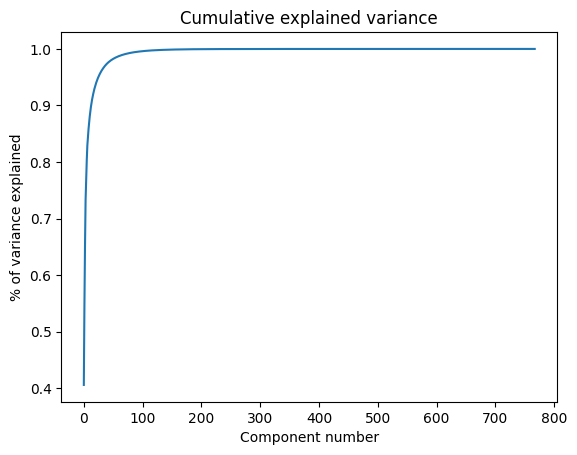

In [ ]:
variance_ratio = sorted_eigenvalues / np.sum(sorted_eigenvalues)
cumulative_variance_ratio = np.cumsum(variance_ratio)
plt.plot(cumulative_variance_ratio)
plt.xlabel('Component number')
plt.ylabel('% of variance explained')
plt.title('Cumulative explained variance')
plt.show()

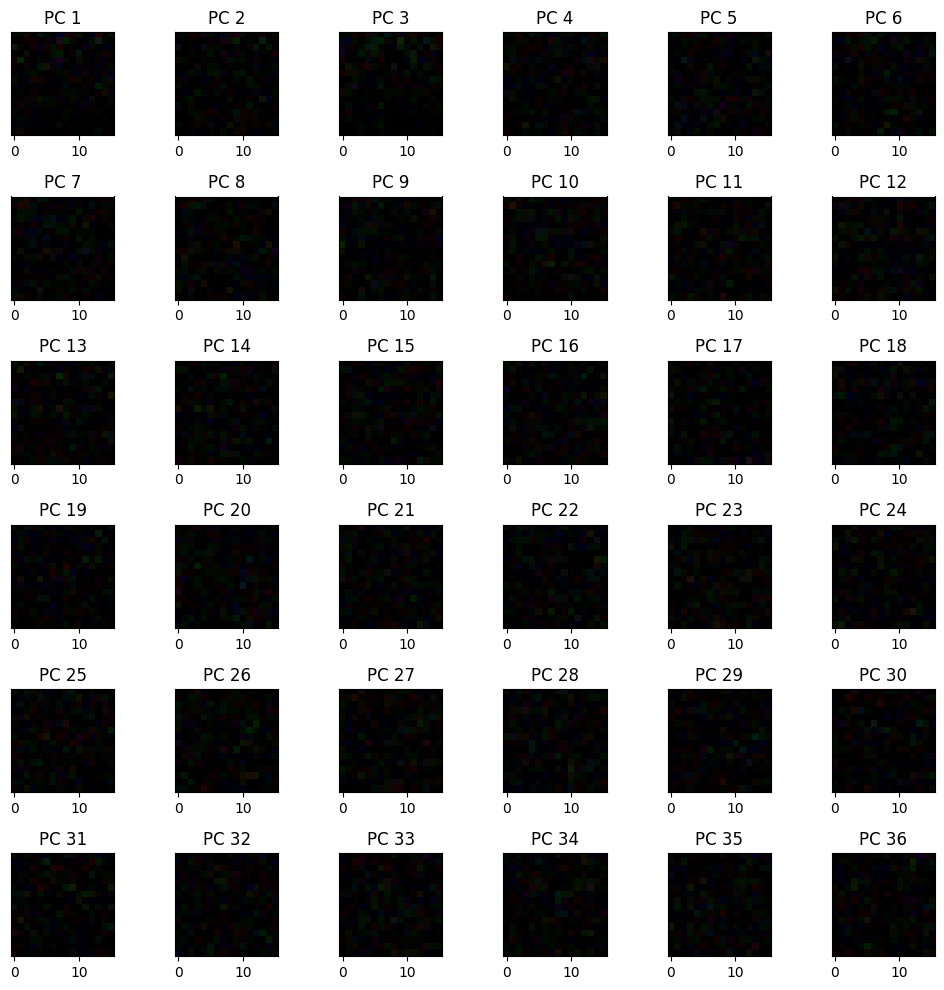

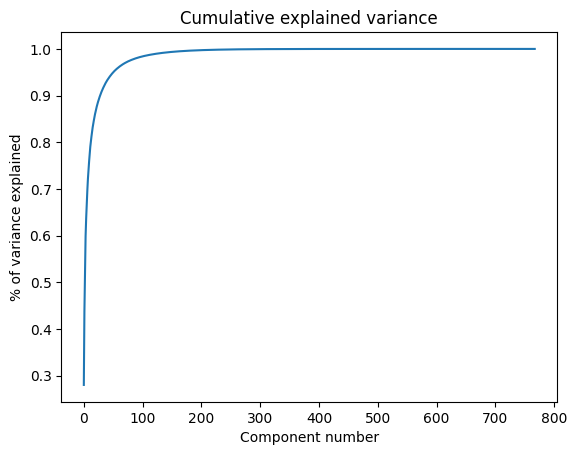

In [ ]:
img = Image.open('station.png')
img = np.array(img)

height, width, _ = img.shape

patch_size = 16

max_row = height // patch_size
max_col = width // patch_size
max_patches = max_row * max_col

patch_nums = np.random.randint(0, max_patches, 1200)

patches = []

for patch_num in patch_nums:
    row = patch_num // max_col
    col = patch_num % max_col
    start_row = row * patch_size
    start_col = col * patch_size

    patch = img[start_row:start_row+patch_size, start_col:start_col+patch_size]

    patches.append(patch)

patch_array = np.asarray(patches)

m, n, l = patch_array.shape[1:]

patch_array = patch_array.reshape(patch_array.shape[0], m*n*l)

mean_patch = np.mean(patch_array, axis=1)
centered_patches = patch_array - mean_patch[:, np.newaxis]

covariance_matrix = np.cov(centered_patches.T)
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(sorted_eigenvectors[i, :].reshape((16, 16, 3)))
    ax.set_yticks([])
    ax.set_title(f'PC {i+1}')
plt.tight_layout()
plt.show()

variance_ratio = sorted_eigenvalues / np.sum(sorted_eigenvalues)
cumulative_variance_ratio = np.cumsum(variance_ratio)
plt.plot(cumulative_variance_ratio)
plt.xlabel('Component number')
plt.ylabel('% of variance explained')
plt.title('Cumulative explained variance')
plt.show()

### 2.2 Compress the image

#### parrot 1pc

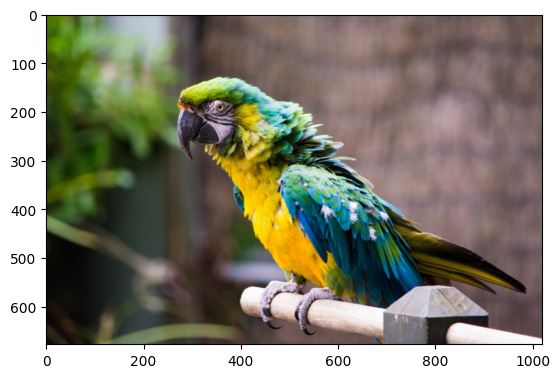

In [ ]:
image = Image.open('parrot.png')
image = np.array(image)

plt.imshow(image)

In [ ]:
height, width, num_channels = image.shape


num_patches_h = height // 16
num_patches_w = width // 16

cropped_image = image[:num_patches_h * 16, :num_patches_w * 16, :]

patch_array = cropped_image.reshape(num_patches_h, 16, num_patches_w, 16, num_channels).transpose(0, 2, 1, 3, 4).reshape(-1, 16, 16, num_channels)

m, n, l = patch_array.shape[1:]

flattened_patches = patch_array.reshape(patch_array.shape[0], m*n*l)

mean_patch = np.mean(flattened_patches, axis=1)
centered_patches = flattened_patches - mean_patch[:, np.newaxis]

covariance_matrix = np.cov(centered_patches.T)
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

feature_vector = np.dot(centered_patches, sorted_eigenvectors[:, :1])

reconstructed_patches = np.tile(mean_patch, (768, 1)).T + np.dot(feature_vector, sorted_eigenvectors[:, :1].T)

reconstructed_image = reconstructed_patches.reshape(patch_array.shape)

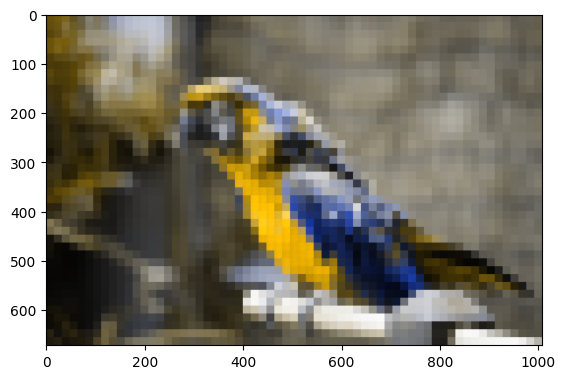

In [ ]:
height, width, _ = (672, 1008, 3)
patch_size = 16

patches_reshaped = reconstructed_image.reshape(num_patches_h, num_patches_w, patch_size, patch_size, 3)

patches_transposed = patches_reshaped.transpose(0, 2, 1, 3, 4)

reconstructed_image1 = patches_transposed.reshape(height, width, 3).astype("float32") / 255.0

plt.imshow(reconstructed_image1)

#### 3pc

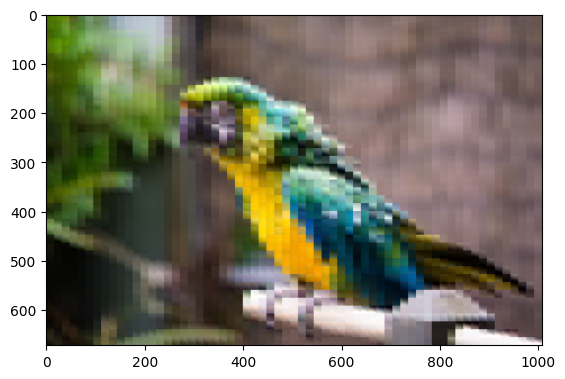

In [ ]:
image = Image.open('parrot.png')
image = np.array(image)

height, width, num_channels = image.shape


num_patches_h = height // 16
num_patches_w = width // 16

cropped_image = image[:num_patches_h * 16, :num_patches_w * 16, :]

patch_array = cropped_image.reshape(num_patches_h, 16, num_patches_w, 16, num_channels).transpose(0, 2, 1, 3, 4).reshape(-1, 16, 16, num_channels)

m, n, l = patch_array.shape[1:]

flattened_patches = patch_array.reshape(patch_array.shape[0], m*n*l)

mean_patch = np.mean(flattened_patches, axis=1)
centered_patches = flattened_patches - mean_patch[:, np.newaxis]

covariance_matrix = np.cov(centered_patches.T)
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

feature_vector = np.dot(centered_patches, sorted_eigenvectors[:, :3])

reconstructed_patches = np.tile(mean_patch, (768, 1)).T + np.dot(feature_vector, sorted_eigenvectors[:, :3].T)

reconstructed_image = reconstructed_patches.reshape(patch_array.shape)

height, width, _ = (672, 1008, 3)
patch_size = 16

patches_reshaped = reconstructed_image.reshape(num_patches_h, num_patches_w, patch_size, patch_size, 3)

patches_transposed = patches_reshaped.transpose(0, 2, 1, 3, 4)

reconstructed_image3 = patches_transposed.reshape(height, width, 3).astype("float32") / 255.0

plt.imshow(reconstructed_image3)

#### 10pc

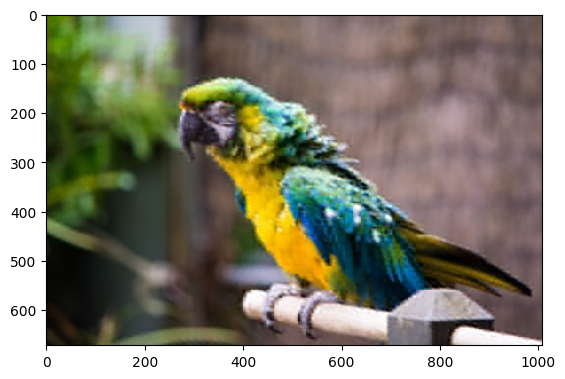

In [ ]:
image = Image.open('parrot.png')
image = np.array(image)

height, width, num_channels = image.shape


num_patches_h = height // 16
num_patches_w = width // 16

cropped_image = image[:num_patches_h * 16, :num_patches_w * 16, :]

patch_array = cropped_image.reshape(num_patches_h, 16, num_patches_w, 16, num_channels).transpose(0, 2, 1, 3, 4).reshape(-1, 16, 16, num_channels)

m, n, l = patch_array.shape[1:]

flattened_patches = patch_array.reshape(patch_array.shape[0], m*n*l)

mean_patch = np.mean(flattened_patches, axis=1)
centered_patches = flattened_patches - mean_patch[:, np.newaxis]

covariance_matrix = np.cov(centered_patches.T)
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

feature_vector = np.dot(centered_patches, sorted_eigenvectors[:, :10])

reconstructed_patches = np.tile(mean_patch, (768, 1)).T + np.dot(feature_vector, sorted_eigenvectors[:, :10].T)

reconstructed_image = reconstructed_patches.reshape(patch_array.shape)

height, width, _ = (672, 1008, 3)
patch_size = 16

patches_reshaped = reconstructed_image.reshape(num_patches_h, num_patches_w, patch_size, patch_size, 3)

patches_transposed = patches_reshaped.transpose(0, 2, 1, 3, 4)

reconstructed_image10 = patches_transposed.reshape(height, width, 3).astype("float32") / 255.0

plt.imshow(reconstructed_image10)

#### 50 pc

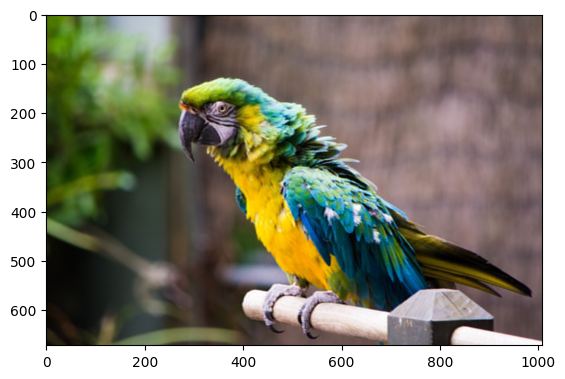

In [ ]:
image = Image.open('parrot.png')
image = np.array(image)

height, width, num_channels = image.shape


num_patches_h = height // 16
num_patches_w = width // 16

cropped_image = image[:num_patches_h * 16, :num_patches_w * 16, :]

patch_array = cropped_image.reshape(num_patches_h, 16, num_patches_w, 16, num_channels).transpose(0, 2, 1, 3, 4).reshape(-1, 16, 16, num_channels)

m, n, l = patch_array.shape[1:]

flattened_patches = patch_array.reshape(patch_array.shape[0], m*n*l)

mean_patch = np.mean(flattened_patches, axis=1)
centered_patches = flattened_patches - mean_patch[:, np.newaxis]

covariance_matrix = np.cov(centered_patches.T)
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

feature_vector = np.dot(centered_patches, sorted_eigenvectors[:, :50])

reconstructed_patches = np.tile(mean_patch, (768, 1)).T + np.dot(feature_vector, sorted_eigenvectors[:, :50].T)

reconstructed_image = reconstructed_patches.reshape(patch_array.shape)

height, width, _ = (672, 1008, 3)
patch_size = 16

patches_reshaped = reconstructed_image.reshape(num_patches_h, num_patches_w, patch_size, patch_size, 3)

patches_transposed = patches_reshaped.transpose(0, 2, 1, 3, 4)

reconstructed_image50 = patches_transposed.reshape(height, width, 3).astype("float32") / 255.0

plt.imshow(reconstructed_image50)

#### 100 pc

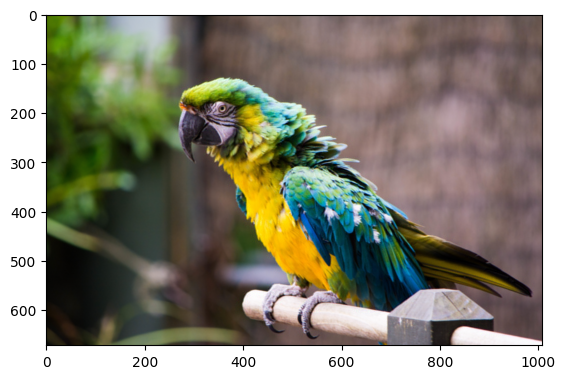

In [ ]:
image = Image.open('parrot.png')
image = np.array(image)

height, width, num_channels = image.shape


num_patches_h = height // 16
num_patches_w = width // 16

cropped_image = image[:num_patches_h * 16, :num_patches_w * 16, :]

patch_array = cropped_image.reshape(num_patches_h, 16, num_patches_w, 16, num_channels).transpose(0, 2, 1, 3, 4).reshape(-1, 16, 16, num_channels)

m, n, l = patch_array.shape[1:]

flattened_patches = patch_array.reshape(patch_array.shape[0], m*n*l)

mean_patch = np.mean(flattened_patches, axis=1)
centered_patches = flattened_patches - mean_patch[:, np.newaxis]

covariance_matrix = np.cov(centered_patches.T)
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

feature_vector = np.dot(centered_patches, sorted_eigenvectors[:, :100])

reconstructed_patches = np.tile(mean_patch, (768, 1)).T + np.dot(feature_vector, sorted_eigenvectors[:, :100].T)

reconstructed_image = reconstructed_patches.reshape(patch_array.shape)

height, width, _ = (672, 1008, 3)
patch_size = 16

patches_reshaped = reconstructed_image.reshape(num_patches_h, num_patches_w, patch_size, patch_size, 3)

patches_transposed = patches_reshaped.transpose(0, 2, 1, 3, 4)

reconstructed_image100 = patches_transposed.reshape(height, width, 3).astype("float32") / 255.0

plt.imshow(reconstructed_image100)

#### station 1 pc

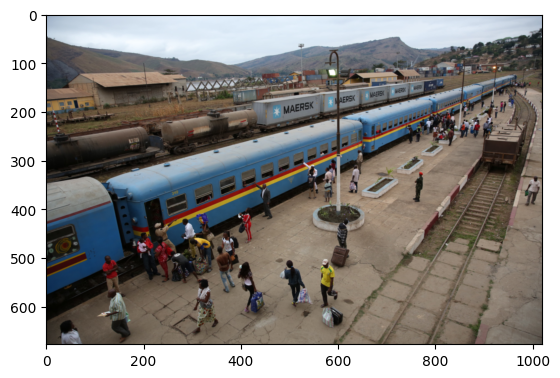

In [ ]:
image = Image.open('station.png')
image = np.array(image)

plt.imshow(image)

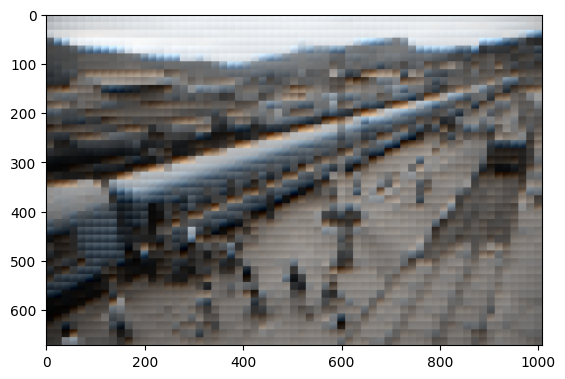

In [ ]:
image = Image.open('station.png')
image = np.array(image)

height, width, num_channels = image.shape


num_patches_h = height // 16
num_patches_w = width // 16

cropped_image = image[:num_patches_h * 16, :num_patches_w * 16, :]

patch_array = cropped_image.reshape(num_patches_h, 16, num_patches_w, 16, num_channels).transpose(0, 2, 1, 3, 4).reshape(-1, 16, 16, num_channels)

m, n, l = patch_array.shape[1:]

flattened_patches = patch_array.reshape(patch_array.shape[0], m*n*l)

mean_patch = np.mean(flattened_patches, axis=1)
centered_patches = flattened_patches - mean_patch[:, np.newaxis]

covariance_matrix = np.cov(centered_patches.T)
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

feature_vector = np.dot(centered_patches, sorted_eigenvectors[:, :1])

reconstructed_patches = np.tile(mean_patch, (768, 1)).T + np.dot(feature_vector, sorted_eigenvectors[:, :1].T)

reconstructed_image = reconstructed_patches.reshape(patch_array.shape)

height, width, _ = (672, 1008, 3)
patch_size = 16

patches_reshaped = reconstructed_image.reshape(num_patches_h, num_patches_w, patch_size, patch_size, 3)

patches_transposed = patches_reshaped.transpose(0, 2, 1, 3, 4)

reconstructed_image1 = patches_transposed.reshape(height, width, 3).astype("float32") / 255.0

plt.imshow(reconstructed_image1)

#### 3 pc

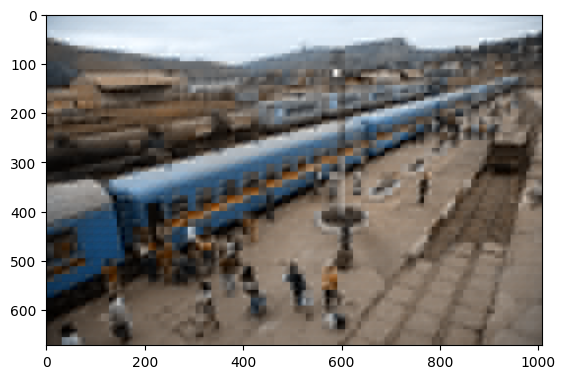

In [ ]:
image = Image.open('station.png')
image = np.array(image)

height, width, num_channels = image.shape

num_patches_h = height // 16
num_patches_w = width // 16

cropped_image = image[:num_patches_h * 16, :num_patches_w * 16, :]

patch_array = cropped_image.reshape(num_patches_h, 16, num_patches_w, 16, num_channels).transpose(0, 2, 1, 3, 4).reshape(-1, 16, 16, num_channels)

m, n, l = patch_array.shape[1:]

flattened_patches = patch_array.reshape(patch_array.shape[0], m*n*l)

mean_patch = np.mean(flattened_patches, axis=1)
centered_patches = flattened_patches - mean_patch[:, np.newaxis]

covariance_matrix = np.cov(centered_patches.T)
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

feature_vector = np.dot(centered_patches, sorted_eigenvectors[:, :3])

reconstructed_patches = np.tile(mean_patch, (768, 1)).T + np.dot(feature_vector, sorted_eigenvectors[:, :3].T)

reconstructed_image = reconstructed_patches.reshape(patch_array.shape)

height, width, _ = (672, 1008, 3)
patch_size = 16

patches_reshaped = reconstructed_image.reshape(num_patches_h, num_patches_w, patch_size, patch_size, 3)

patches_transposed = patches_reshaped.transpose(0, 2, 1, 3, 4)

reconstructed_image3 = patches_transposed.reshape(height, width, 3).astype("float32") / 255.0

plt.imshow(reconstructed_image3)

#### 10 pc

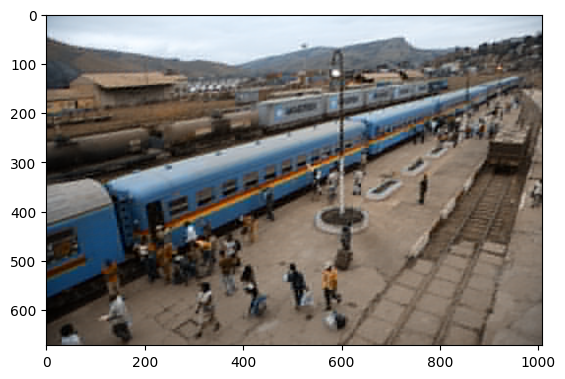

In [ ]:
image = Image.open('station.png')
image = np.array(image)

height, width, num_channels = image.shape

num_patches_h = height // 16
num_patches_w = width // 16

cropped_image = image[:num_patches_h * 16, :num_patches_w * 16, :]

patch_array = cropped_image.reshape(num_patches_h, 16, num_patches_w, 16, num_channels).transpose(0, 2, 1, 3, 4).reshape(-1, 16, 16, num_channels)

m, n, l = patch_array.shape[1:]

flattened_patches = patch_array.reshape(patch_array.shape[0], m*n*l)

mean_patch = np.mean(flattened_patches, axis=1)
centered_patches = flattened_patches - mean_patch[:, np.newaxis]

covariance_matrix = np.cov(centered_patches.T)
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

feature_vector = np.dot(centered_patches, sorted_eigenvectors[:, :10])

reconstructed_patches = np.tile(mean_patch, (768, 1)).T + np.dot(feature_vector, sorted_eigenvectors[:, :10].T)

reconstructed_image = reconstructed_patches.reshape(patch_array.shape)

height, width, _ = (672, 1008, 3)
patch_size = 16

patches_reshaped = reconstructed_image.reshape(num_patches_h, num_patches_w, patch_size, patch_size, 3)

patches_transposed = patches_reshaped.transpose(0, 2, 1, 3, 4)

reconstructed_image10 = patches_transposed.reshape(height, width, 3).astype("float32") / 255.0

plt.imshow(reconstructed_image10)

#### 50 pc

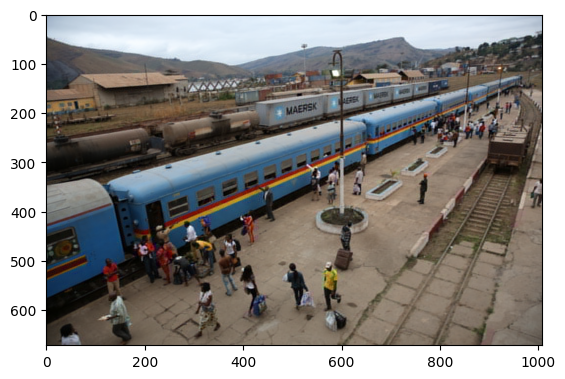

In [ ]:
image = Image.open('station.png')
image = np.array(image)

height, width, num_channels = image.shape

num_patches_h = height // 16
num_patches_w = width // 16

cropped_image = image[:num_patches_h * 16, :num_patches_w * 16, :]

patch_array = cropped_image.reshape(num_patches_h, 16, num_patches_w, 16, num_channels).transpose(0, 2, 1, 3, 4).reshape(-1, 16, 16, num_channels)

m, n, l = patch_array.shape[1:]

flattened_patches = patch_array.reshape(patch_array.shape[0], m*n*l)

mean_patch = np.mean(flattened_patches, axis=1)
centered_patches = flattened_patches - mean_patch[:, np.newaxis]

covariance_matrix = np.cov(centered_patches.T)
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

feature_vector = np.dot(centered_patches, sorted_eigenvectors[:, :50])

reconstructed_patches = np.tile(mean_patch, (768, 1)).T + np.dot(feature_vector, sorted_eigenvectors[:, :50].T)

reconstructed_image = reconstructed_patches.reshape(patch_array.shape)

height, width, _ = (672, 1008, 3)
patch_size = 16

patches_reshaped = reconstructed_image.reshape(num_patches_h, num_patches_w, patch_size, patch_size, 3)

patches_transposed = patches_reshaped.transpose(0, 2, 1, 3, 4)

reconstructed_image50 = patches_transposed.reshape(height, width, 3).astype("float32") / 255.0

plt.imshow(reconstructed_image50)

#### 100 pc

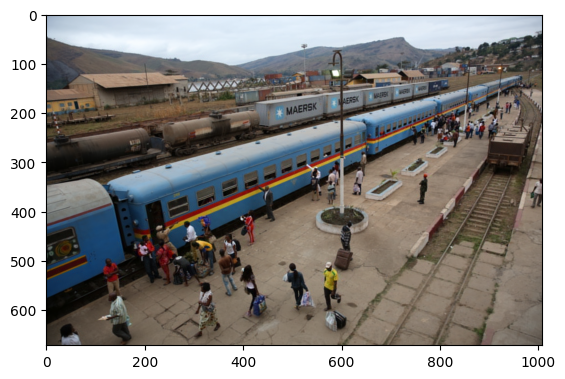

In [ ]:
image = Image.open('station.png')
image = np.array(image)

height, width, num_channels = image.shape

num_patches_h = height // 16
num_patches_w = width // 16

cropped_image = image[:num_patches_h * 16, :num_patches_w * 16, :]

patch_array = cropped_image.reshape(num_patches_h, 16, num_patches_w, 16, num_channels).transpose(0, 2, 1, 3, 4).reshape(-1, 16, 16, num_channels)

m, n, l = patch_array.shape[1:]

flattened_patches = patch_array.reshape(patch_array.shape[0], m*n*l)

mean_patch = np.mean(flattened_patches, axis=1)
centered_patches = flattened_patches - mean_patch[:, np.newaxis]

covariance_matrix = np.cov(centered_patches.T)
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

feature_vector = np.dot(centered_patches, sorted_eigenvectors[:, :100])

reconstructed_patches = np.tile(mean_patch, (768, 1)).T + np.dot(feature_vector, sorted_eigenvectors[:, :100].T)

reconstructed_image = reconstructed_patches.reshape(patch_array.shape)

height, width, _ = (672, 1008, 3)
patch_size = 16

patches_reshaped = reconstructed_image.reshape(num_patches_h, num_patches_w, patch_size, patch_size, 3)

patches_transposed = patches_reshaped.transpose(0, 2, 1, 3, 4)

reconstructed_image100 = patches_transposed.reshape(height, width, 3).astype("float32") / 255.0

plt.imshow(reconstructed_image100)